# Clustering Code Along

We'll be working with a real data set about seeds, from UCI repository: https://archive.ics.uci.edu/ml/datasets/seeds.

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for 
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin. 

The data set can be used for the tasks of classification and cluster analysis.


Attribute Information:

To construct the data, seven geometric parameters of wheat kernels were measured: 
1. area A, 
2. perimeter P, 
3. compactness C = 4*pi*A/P^2, 
4. length of kernel, 
5. width of kernel, 
6. asymmetry coefficient 
7. length of kernel groove. 
All of these parameters were real-valued continuous.

Let's see if we can cluster them in to 3 groups with K-means!

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()

In [2]:
from pyspark.ml.clustering import KMeans

# Loads data.
dataset = spark.read.csv("seeds_dataset.csv",header=True,inferSchema=True)

In [3]:
dataset.head()

Row(area=15.26, perimeter=14.84, compactness=0.871, length_of_kernel=5.763, width_of_kernel=3.312, asymmetry_coefficient=2.221, length_of_groove=5.22)

In [4]:
dataset.describe().show()

+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|summary|              area|         perimeter|         compactness|   length_of_kernel|   width_of_kernel|asymmetry_coefficient|   length_of_groove|
+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|  count|               210|               210|                 210|                210|               210|                  210|                210|
|   mean|14.847523809523816|14.559285714285718|  0.8709985714285714|  5.628533333333335| 3.258604761904762|   3.7001999999999997|  5.408071428571429|
| stddev|2.9096994306873647|1.3059587265640225|0.023629416583846364|0.44306347772644983|0.3777144449065867|   1.5035589702547392|0.49148049910240543|
|    min|             10.59|             12.41|              0.8081|              4.899|            

## Format the Data

In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [6]:
dataset.columns

['area',
 'perimeter',
 'compactness',
 'length_of_kernel',
 'width_of_kernel',
 'asymmetry_coefficient',
 'length_of_groove']

In [7]:
vec_assembler = VectorAssembler(inputCols = dataset.columns, outputCol='features')

In [8]:
final_data = vec_assembler.transform(dataset)

## Scale the Data
It is a good idea to scale our data to deal with the curse of dimensionality: https://en.wikipedia.org/wiki/Curse_of_dimensionality

In [9]:
from pyspark.ml.feature import StandardScaler

In [10]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

In [11]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [12]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

## Train the Model and Evaluate

In [13]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)

In [14]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(final_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 429.07559671506715


In [15]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.87257659 10.88120146 37.27692543 12.3410157   8.55443412  1.81649011
 10.32998598]
[ 4.06105916 10.13979506 35.80536984 11.82133095  7.50395937  3.27184732
 10.42126018]
[ 6.31670546 12.37109759 37.39491396 13.91155062  9.748067    2.39849968
 12.2661748 ]


In [16]:
model.transform(final_data).select('prediction').show()

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         2|
|         2|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
+----------+
only showing top 20 rows



In [17]:
import numpy as np

In [18]:
cost = np.zeros(20)
for k in range(2,20):
    print(k)
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    cost[k] = model.computeCost(final_data)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


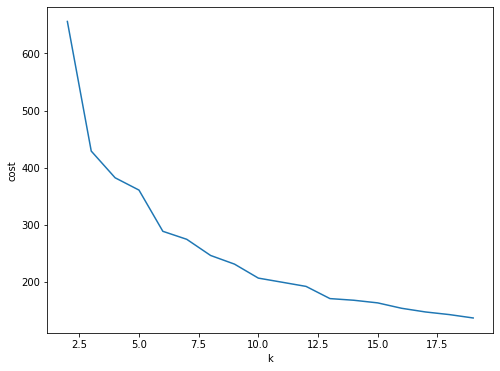

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

Now you are ready for your consulting Project!
# Great Job!